In [17]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from networkx.algorithms import community

 Influence Diffusion (Independent Cascade Model)

In [ ]:
def simulate_ic(G, seeds, p=0.1):
    active = set(seeds)
    newly_active = set(seeds)

    while newly_active:
        next_new = set()
        for u in newly_active:
            for v in G.neighbors(u):
                if v not in active:
                    if random.random() < p:
                        next_new.add(v)
        newly_active = next_new
        active |= newly_active
    return active

Influence Diffusion (Linear Threshold Model)

In [ ]:
def simulate_lt(G, seeds):
    thresholds = {node: random.uniform(0, 1) for node in G.nodes()}
    active = set(seeds)
    changed = True

    while changed:
        changed = False
        for node in G.nodes():
            if node not in active:
                neighbors = list(G.predecessors(node)) if G.is_directed() else list(G.neighbors(node))
                active_neighbors = len([n for n in neighbors if n in active])
                if neighbors:
                    if (active_neighbors / len(neighbors)) >= thresholds[node]:
                        active.add(node)
                        changed = True
    return active

Main analysis function

In [ ]:
def analyze_influence(graphs, ks=[5,10,20,25,30], trials=10, p=0.1, model="IC"):
    results = {}
    tables = {}
    for name, G in graphs.items():
        n = G.number_of_nodes()
        cent = {
            'Degree': dict(nx.degree_centrality(G)),
            'Closeness': dict(nx.closeness_centrality(G)),
            'Betweenness': dict(nx.betweenness_centrality(G)),
            'PageRank': dict(nx.pagerank(G))
        }
        results[name] = {}
        data = []
        for measure, scores in cent.items():
            sorted_nodes = sorted(scores, key=lambda x: scores[x], reverse=True)
            avg_fracs = []
            for k in ks:
                seeds = sorted_nodes[:k]
                influences = []
                for _ in range(trials):
                    if model == "IC":
                        active = simulate_ic(G, seeds, p)
                    elif model == "LT":
                        active = simulate_lt(G, seeds)
                    influences.append(len(active))
                avg_inf = np.mean(influences)
                avg_fracs.append(avg_inf / n)
                data.append([measure, k, avg_inf / n])
            results[name][measure] = avg_fracs
        tables[name] = pd.DataFrame(data, columns=['Centrality', 'k', 'Influence'])
    return results, tables

Plotting function

In [ ]:
def plot_results(results, ks, model="IC"):
    for graph_name, measures in results.items():
        plt.figure(figsize=(8, 5))
        for measure, fracs in measures.items():
            plt.plot(ks, fracs, marker='o', label=measure)
        plt.title(f'{model} Model Influence on {graph_name}')
        plt.xlabel('Seed Set Size (k)')
        plt.ylabel('Average Influence (fraction)')
        plt.xticks(ks)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
def plot_comparison_bar(tables, model):
    for name, df in tables.items():
        pivot_df = df.pivot(index='k', columns='Centrality', values='Influence')
        pivot_df.plot(kind='bar', figsize=(10, 6))
        plt.title(f'Influence Comparison (Bar) - {model} Model - {name}')
        plt.xlabel('Seed Set Size (k)')
        plt.ylabel('Average Influence (fraction)')
        plt.legend(title='Centrality')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
def plot_centrality_comparison(results_ic, results_lt, ks):
    for graph_name in results_ic:
        plt.figure(figsize=(10, 6))
        for centrality in results_ic[graph_name]:
            plt.plot(ks, results_ic[graph_name][centrality], label=f'IC - {centrality}', linestyle='--')
            plt.plot(ks, results_lt[graph_name][centrality], label=f'LT - {centrality}', linestyle='-')
        plt.title(f'IC vs LT Influence Comparison - {graph_name}')
        plt.xlabel('Seed Set Size (k)')
        plt.ylabel('Average Influence (fraction)')
        plt.xticks(ks)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Tabular Output

In [ ]:
def show_tables(tables):
    for name, df in tables.items():
        print(f"\nInfluence Table for {name}:")
        print(df.pivot(index='k', columns='Centrality', values='Influence').round(3))

Example usage

Running IC model...


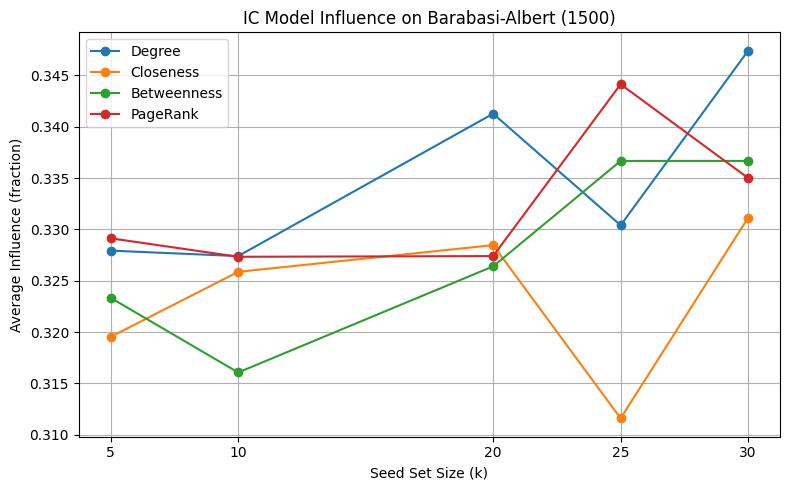

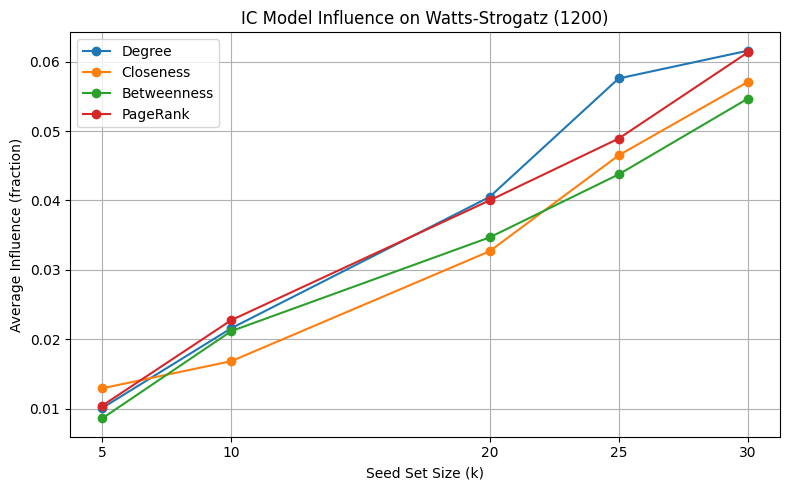

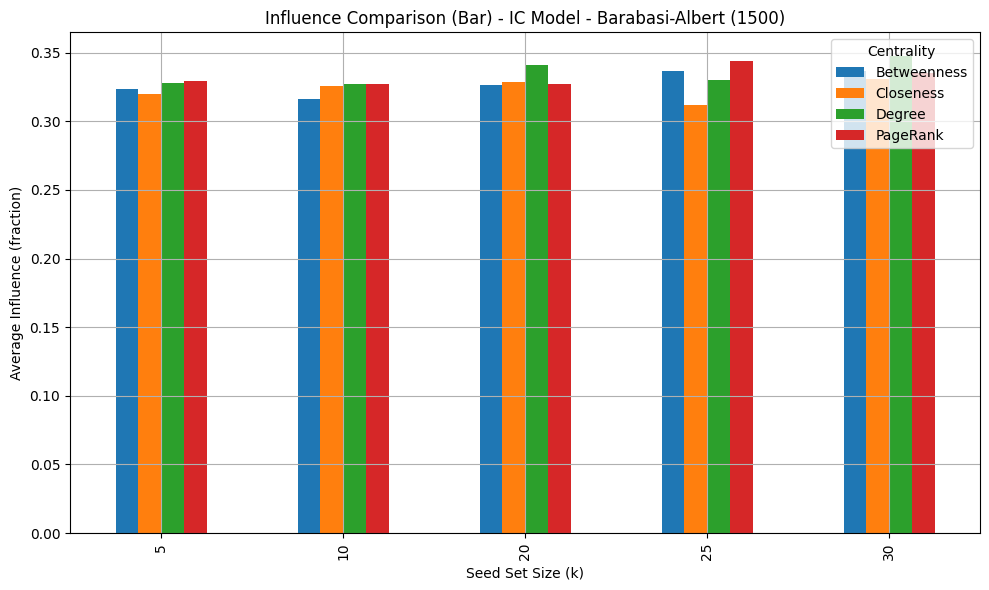

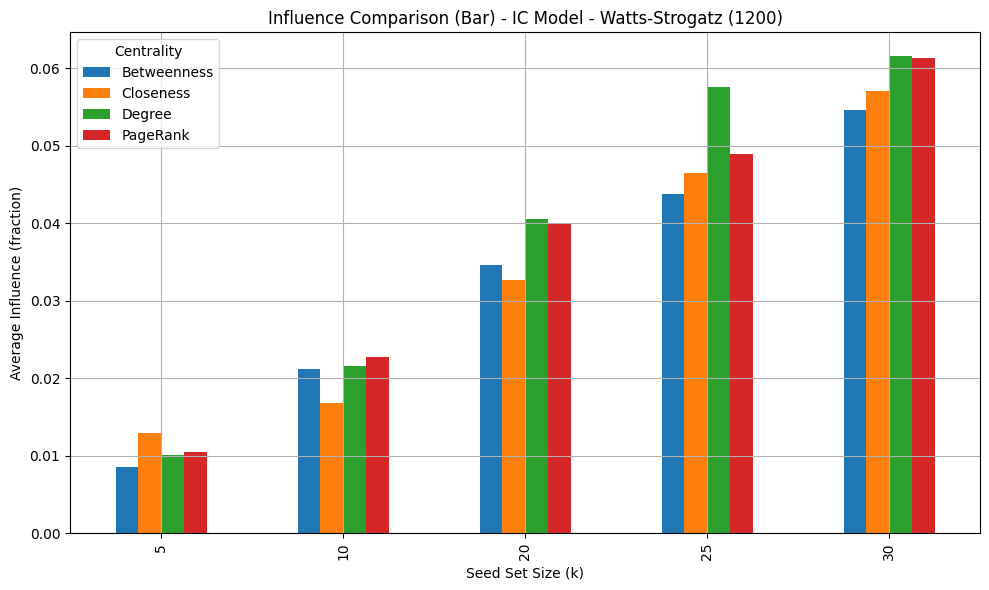


Influence Table for Barabasi-Albert (1500):
Centrality  Betweenness  Closeness  Degree  PageRank
k                                                   
5                 0.323      0.320   0.328     0.329
10                0.316      0.326   0.327     0.327
20                0.326      0.328   0.341     0.327
25                0.337      0.312   0.330     0.344
30                0.337      0.331   0.347     0.335

Influence Table for Watts-Strogatz (1200):
Centrality  Betweenness  Closeness  Degree  PageRank
k                                                   
5                 0.009      0.013   0.010     0.010
10                0.021      0.017   0.022     0.023
20                0.035      0.033   0.040     0.040
25                0.044      0.046   0.058     0.049
30                0.055      0.057   0.062     0.061

Running LT model...


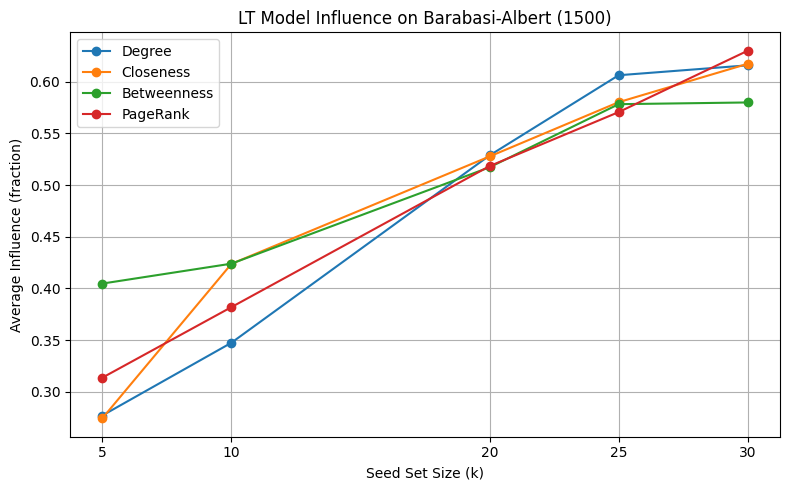

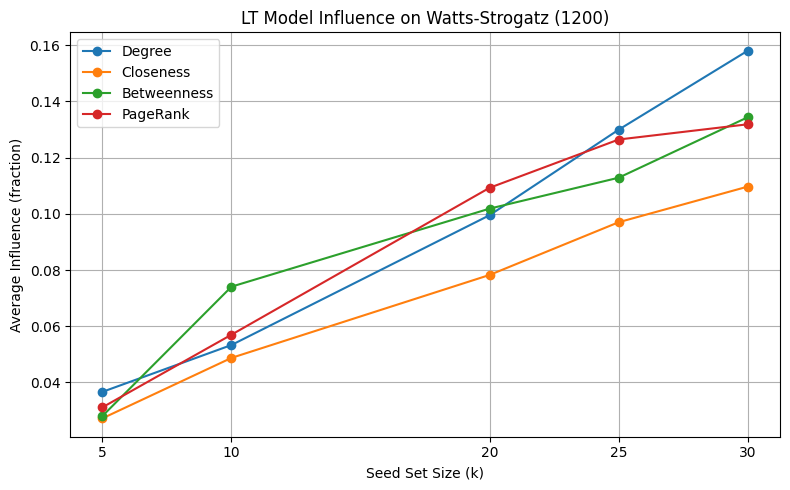

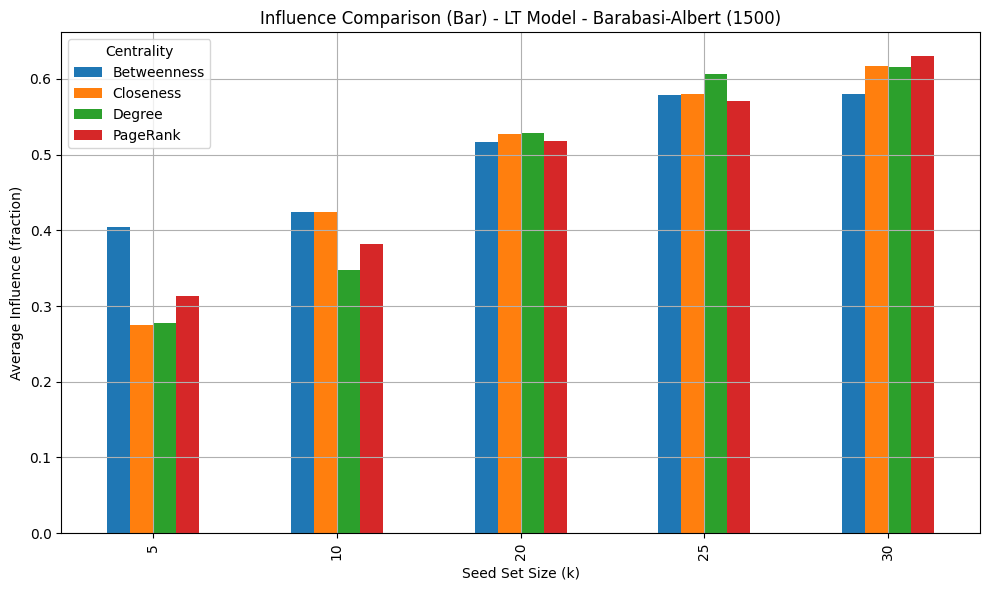

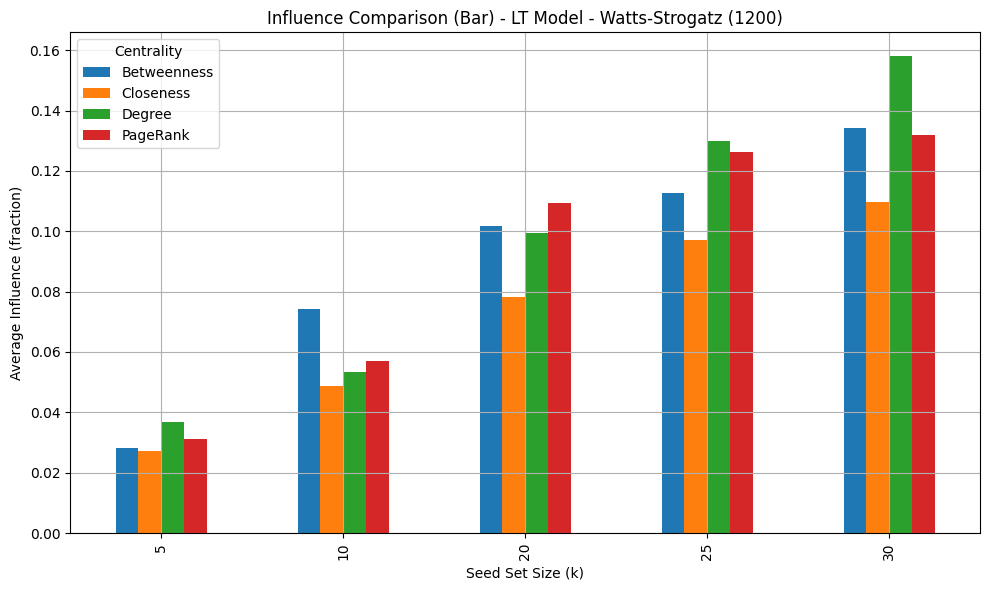


Influence Table for Barabasi-Albert (1500):
Centrality  Betweenness  Closeness  Degree  PageRank
k                                                   
5                 0.405      0.274   0.277     0.314
10                0.424      0.424   0.347     0.382
20                0.517      0.528   0.529     0.518
25                0.578      0.580   0.606     0.571
30                0.580      0.617   0.616     0.630

Influence Table for Watts-Strogatz (1200):
Centrality  Betweenness  Closeness  Degree  PageRank
k                                                   
5                 0.028      0.027   0.037     0.031
10                0.074      0.049   0.053     0.057
20                0.102      0.078   0.100     0.109
25                0.113      0.097   0.130     0.126
30                0.134      0.110   0.158     0.132


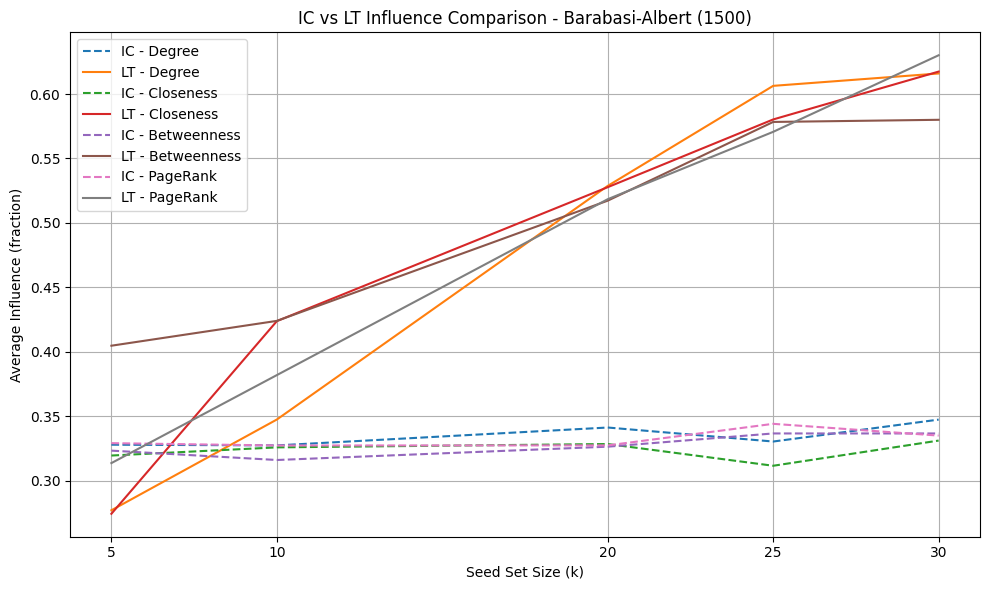

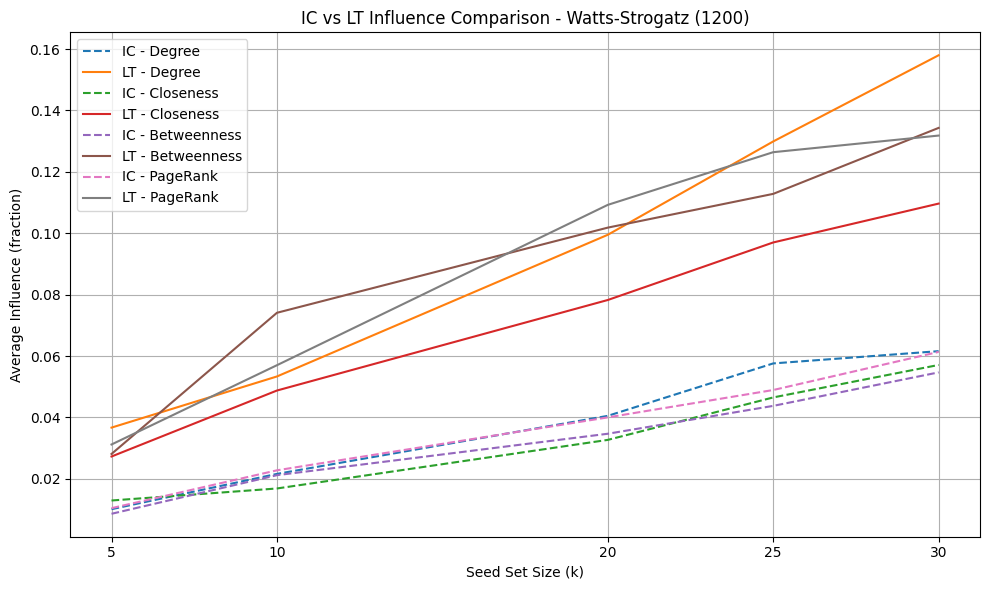

In [ ]:
if __name__ == '__main__':
    G1 = nx.generators.random_graphs.barabasi_albert_graph(1500, 5)
    G2 = nx.generators.random_graphs.watts_strogatz_graph(1200, 6, 0.1)

    graphs = {'Barabasi-Albert (1500)': G1, 'Watts-Strogatz (1200)': G2}
    ks = [5, 10, 20, 25, 30]
    trials = 10
    p = 0.1

    # Run for both IC and LT models
    print("Running IC model...")
    results_ic, tables_ic = analyze_influence(graphs, ks=ks, trials=trials, p=p, model="IC")
    plot_results(results_ic, ks, model="IC")
    plot_comparison_bar(tables_ic, model="IC")
    show_tables(tables_ic)

    print("\nRunning LT model...")
    results_lt, tables_lt = analyze_influence(graphs, ks=ks, trials=trials, model="LT")
    plot_results(results_lt, ks, model="LT")
    plot_comparison_bar(tables_lt, model="LT")
    show_tables(tables_lt)

    # Comparison between IC and LT models
    plot_centrality_comparison(results_ic, results_lt, ks)